Practical 1: The goal of this practical session is to build backprop from scratch and a small neural network (MLP).

Please return your notebook right at the end of the session.  You then have a week to return an updated version.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

In [3]:
# code to display a network - do not modify this cell
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    layer_colors = ["#FFCCCC", "#CCFFCC", "#CCCCFF", "#FFCC99", "#99CCFF"]
    
    def get_color(node):
        if node._op == '+': return layer_colors[0]
        elif node._op == '*': return layer_colors[1]
        elif node._op == 'tanh': return layer_colors[2]
        # Ajoutez d'autres conditions ici pour d'autres opérations ou couches
        return layer_colors[-1]  # Couleur par défaut
    
    for n in nodes:
        color = get_color(n)
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record', style='filled', fillcolor=color)
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+') ##
    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    return out

  def __mul__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*') ##
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def __pow__(self, other): # ex. 6
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** (other), (self,), '**')
    def _backward():
      self.grad += (other * self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out
  
  def exp(self):
    out = Value(math.exp(self.data), (self,), 'exp')
    def _backward():
        self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def __tanh__(self):
    exp_2x = (self * 2).__exp__()
    out = (exp_2x - 1) / (exp_2x + 1)
    def _backward():
      self.grad += (1 - out.data ** 2) * out.grad

    out._backward = _backward
    return out

  
  def __rmul__(self, other): # other * self
    return self * other 

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
      t = (math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1)
      out = Value(t, (self, ), "tanh")
      def _backward():
        self.grad += (1.0 - t**2) * out.grad
      out._backward = _backward
      return out
  
  def relu(self): # pour la dernière qst
      out = Value(max(self.data, 0), (self,), "relu")

      def _backward():
          self.grad += (out.data > 0) * out.grad  # (out >0) est un booléen donc vaux 0 ou 1
      out._backward = _backward
      return out
  def leaky_relu(self, alpha=0.01):
    out = Value(self.data if self.data > 0 else alpha * self.data, (self,), "leaky_relu")

    def _backward():
      self.grad += (1 if self.data > 0 else alpha) * out.grad  # Pente 1 pour x > 0, alpha sinon

    out._backward = _backward
    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
  def zerograd(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 0
    for node in reversed(topo):
      node.grad=0    

In [5]:
# Exercise 1: fill in __add__ and __mul__ in the Value class to enable the following function. You should get -8.0 as a result.
def lol():

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    return L

print(lol().data)

-8.0


In [6]:
lol()

Value(data=-8.0)

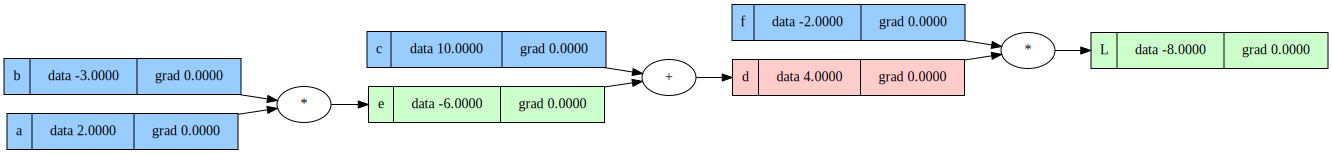

In [7]:
draw_dot(lol())

In [8]:
# Exercise 2: use the lol_grad() function below to manually compute dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    d += h
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data


    print("dl/dd = ",(L2-L1)/h)

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    f += h 
    L = d*f; L.label='L'
    Lf = L.data


    print("dl/df = ",(Lf-L1)/h)

    ### dl/de
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    e+= h
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    Le = L.data

    print("dl/de = ",(Le-L1)/h)

    ### dl/dc

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    c += h
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    Lc = L.data

    print("dl/dc = ",(Lc-L1)/h)

    ### dl/da

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    a += h
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    La = L.data

    print("dl/da = ",(La-L1)/h)

    ### dl/db

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b += h
    c = Value(10.0, label='c')
    a += h
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    Lb = L.data

    print("dl/db = ",(Lb-L1)/h)


In [9]:
# report the values for dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db in this cell
# dL/df = 4.0
# etc.
lol_grad()


dl/dd =  -1.9999999999953388
dl/df =  3.9999999999995595
dl/de =  -1.9999999999953388
dl/dc =  -1.9999999999953388
dl/da =  6.000000000021544
dl/db =  1.9997999999965543


In [10]:
# Exercise 3: implement the function tanh() in the Value class and build the following network
# input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1z2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



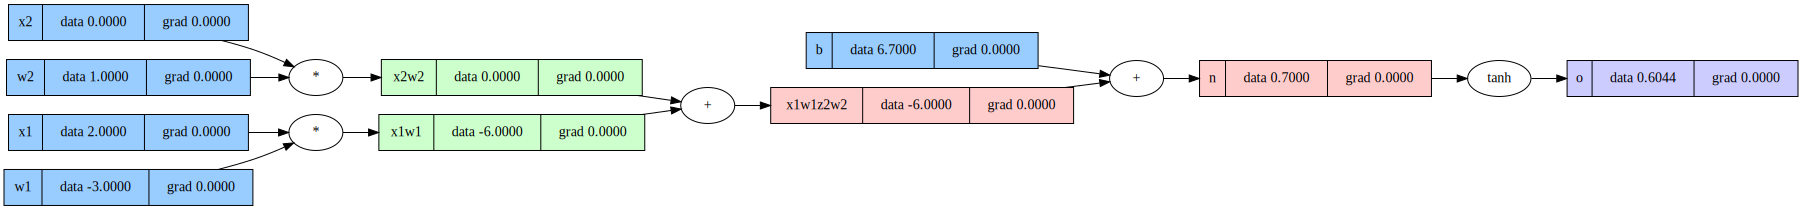

In [11]:
# o.data should be 0.6044
draw_dot(o)

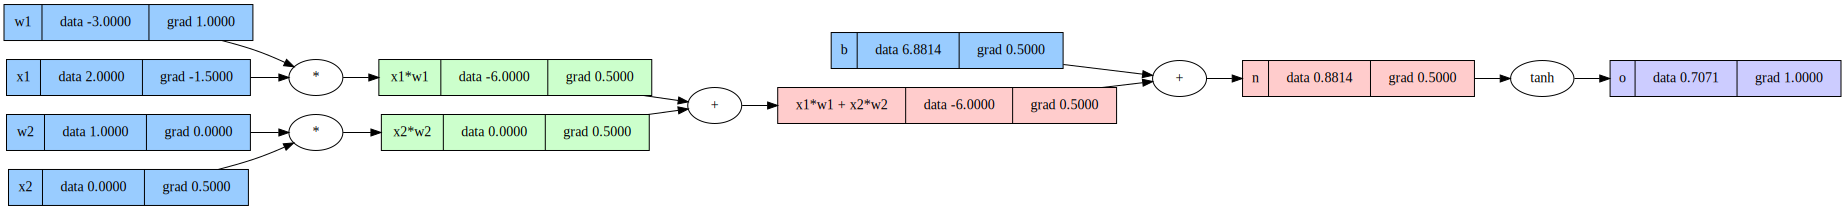

In [12]:
# Exercise 4: Implement the backward() function in each Value's operator: __add__, __mul__, __tanh__ and assign it to _backward
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
#e = (2*n).exp()
#o = (e - 1) / (e + 1)
o = n.tanh()
# ----
o.label = 'o'
o.backward()
draw_dot(o)

 # expected results:
 # o.data should be 0.7071
 # w1.grad = 1.0
 # w2.grad = 0.0
 # x1.grad = -1.5
 # x2.grad = 0.5

In [13]:
# Exercise 5: why are we using self.grad += and not self.grad = in the backward() functions?  Answer as a comment in this cell. 
# Hint: create a Value "a" and then b = a + a. What happens when you do b.backward()?

# we use += x instead of = because we want don't want to "crush" (i don't know if its the right word in english for this purpose)
# the past operations that might have affect the gradient

a = Value(5.0, label='a')
b = a + a 

b.grad = 1.0
b._backward() 

print(a.grad)

2.0


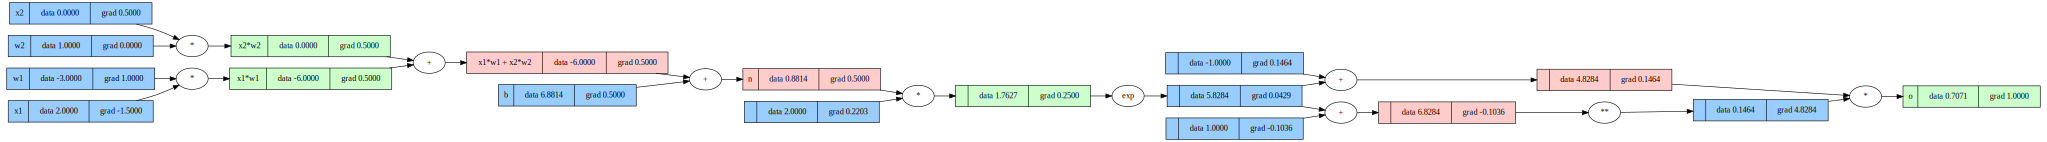

In [14]:
# Exercise 6: replace the tanh() function by a combination of exp() and division.  Implement the __exp__ and __pow__ functions in Value. You should get the same results as before.
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
#o = ... (no tanh allowed)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [15]:
# Congratulations!  You "unlocked" the basic layer of pytorch.  Now you know what happens under the hood of the following code. Check that you get the same output as before for grad values.

import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())
# seems to match


0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [16]:
# Exercise 7: Let's build an MLP based on the Value class.  Fill in the Neuron, Layer and MLP classes.

In [17]:
def flatten(xss):
    """simple function to flatten a list of list
    """
    return [x for xs in xss for x in xs]

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum([wi * xi for wi, xi in zip(self.w, x)]) + self.b
    #act = self.w * x + b
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return flatten([n.parameters() for n in self.neurons])
  

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def _forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x  
  def __call__(self, x):
    if isinstance(x[0], list):
      out = [self._forward(el) for el in x]
    else:
      out = self._forward(x)

    return out
  
  def parameters(self):
    return flatten([layer.parameters() for layer in self.layers])

In [18]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.5837456477969832)

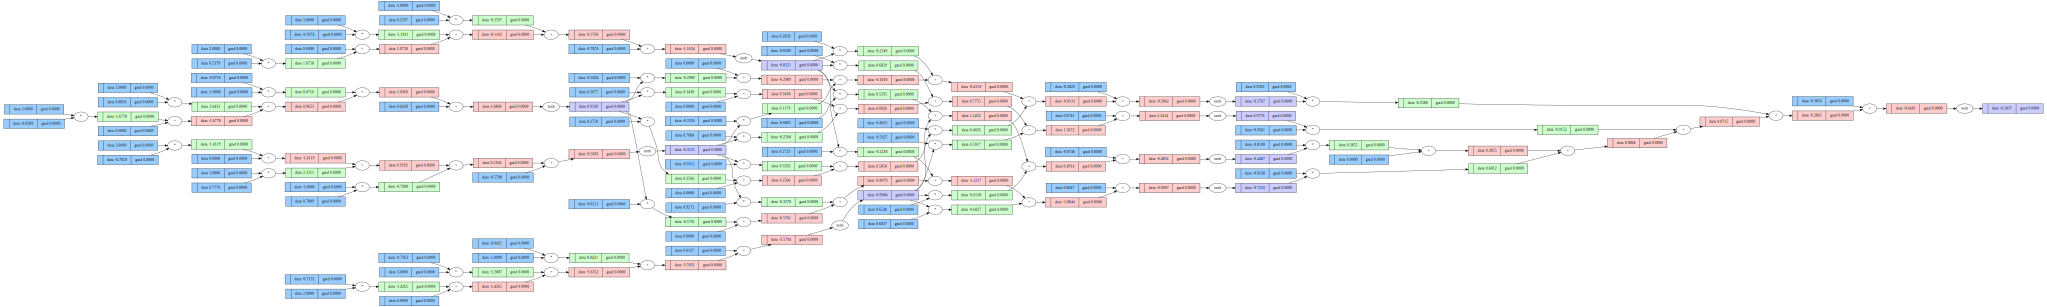

In [19]:
draw_dot(n(x))

In [20]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [21]:
# Exercise 8: write a training loop

def loss_fcn(ypred, ys):
    return sum([(a-b)**2 for (a,b) in zip(ypred, ys)])

lr = 1e-1
for k in range(20):
    # forward pass (compute the loss)
    ypred = n(xs)
    loss =  loss_fcn(ypred, ys)# MSE between ypred and ground-truth
    loss.backward()
    # update
    for param in n.parameters():
        param.data -= lr * param.grad
    print(k, loss.data)
    loss.zerograd()

0 8.40789406869516
1 5.210958770944766
2 5.419322599413793
3 1.3641965460415963
4 0.15743383445968812
5 0.08179573813167339
6 0.06581754403527072
7 0.056894507197238674
8 0.05067063203231586
9 0.04586262753395487
10 0.041944266868065475
11 0.038649853830489925
12 0.035823934814375985
13 0.03336549967120436
14 0.031203903213330483
15 0.029287125799020087
16 0.027575434759968515
17 0.02603765944744539
18 0.024648846218247537
19 0.023388698879320612


In [22]:
_ = [print(y_pred.data, y) for y_pred, y in zip(n(xs), ys)]

0.9270279504589334 1.0
-0.9158774463616314 -1.0
-0.9380374219330981 -1.0
0.9225428472310352 1.0


In [23]:
# Exercise 9: why do you need to reset the grads to zero at every training step?  Answer as a comment in this cell.

# Otherwise the grads will accumulate and will no longer have sense. Since we update the grad using +=
# we need to reset it after (or before) we update our parameters



0 13.707059472205916
50 5.443255472024866
100 4.991294599560579
150 4.660637846982532
200 4.331683092064821
250 3.9559407327389833
300 3.4958607819256264
350 2.933830625547163
400 2.301224598452177
450 1.691867968804794
500 1.2091934668975228
550 0.8901434034200729
600 0.7030323238935398
650 0.5970866107588565
700 0.5339208962120072
750 0.49173977346246267


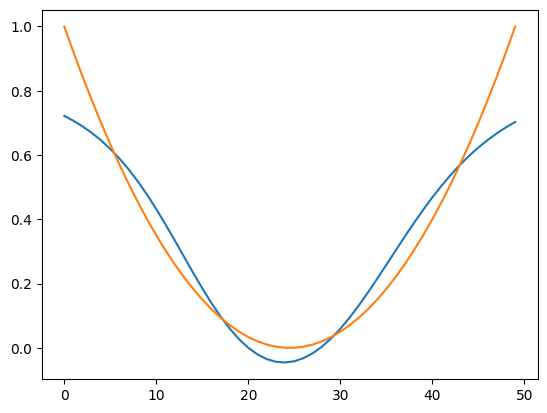

In [24]:
# Exercise 10 (*): try to approximate the n^2 function with a 2-layer MLP.  why is it so hard?

#TODO: Terminer cet exercice 

x = np.linspace(-1, 1, 50)
y = x**2

x = [[el] for el in x]
y = [el for el in y]

n = MLP(1, [4, 4, 1])



lr = 1e-3
for k in range(800):
    # forward pass (compute the loss)
    ypred = n(x)
    loss =  loss_fcn(ypred, y)# MSE between ypred and ground-truth
    loss.backward()
    # update
    for param in n.parameters():
        param.data -= lr * param.grad
    
    if k%50 == 0:
        print(k, loss.data)
    loss.zerograd()

plt.plot([res.data for res in n(x)])
plt.plot(y)


# Ici dans l'exercice j'avais supposé que x devait etre compris entre -1 et 1 car l'output ne peut pas etre supérieur a 1 en raison du tanh. on voit directement que
# le modèle ne peut pas apprendre la fonction carré si x n'est pas entre 0 et 1. De plus le tanh 

In [25]:
def flatten(xss):
    """simple function to flatten a list of list
    """
    return [x for xs in xss for x in xs]

class NeuronRelu:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum([wi * xi for wi, xi in zip(self.w, x)]) + self.b
    #act = self.w * x + b
    out = act.leaky_relu()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class LayerRelu:
  
  def __init__(self, nin, nout):
    self.neurons = [NeuronRelu(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return flatten([n.parameters() for n in self.neurons])
  

class MLPRelu:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [LayerRelu(sz[i], sz[i+1]) for i in range(len(nouts))]

  def _forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x  
  def __call__(self, x):
    if isinstance(x[0], list):
      out = [self._forward(el) for el in x]
    else:
      out = self._forward(x)

    return out
  
  def parameters(self):
    return flatten([layer.parameters() for layer in self.layers])

0 152.27232314473483


/tmp/ipykernel_49218/333428043.py:34: RuntimeWarning: overflow encountered in scalar power
  out = Value(self.data ** (other), (self,), '**')
/tmp/ipykernel_49218/333428043.py:27: RuntimeWarning: overflow encountered in scalar multiply
  self.grad += other.data * out.grad
/tmp/ipykernel_49218/333428043.py:28: RuntimeWarning: overflow encountered in scalar multiply
  other.grad += self.data * out.grad
/tmp/ipykernel_49218/333428043.py:28: RuntimeWarning: invalid value encountered in scalar add
  other.grad += self.data * out.grad


50 nan
100 nan
150 nan
200 nan
250 nan
300 nan
350 nan
400 nan
450 nan
500 nan
550 nan
600 nan
650 nan
700 nan
750 nan
800 nan
850 nan
900 nan
950 nan


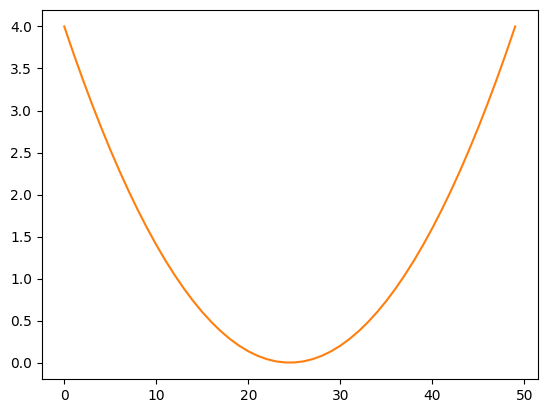

In [26]:

x = np.linspace(-2, 2, 50)
y = x**2

x = [[el] for el in x]
y = [el for el in y]

n = MLPRelu(1, [4, 4, 1])



lr = 1e-1
for k in range(1000):
    # forward pass (compute the loss)
    ypred = n(x)
    loss =  loss_fcn(ypred, y)# MSE between ypred and ground-truth
    loss.backward()
    # update
    for param in n.parameters():
        param.data -= lr * param.grad
    
    if k%50 == 0:
        print(k, loss.data)
    loss.zerograd()

plt.plot([res.data for res in n(x)])
plt.plot(y)


# Ici dans l'exercice j'avais supposé que x devait etre compris entre -1 et 1 car l'output ne peut pas etre supérieur a 1 en raison du tanh. on voit directement que
# le modèle ne peut pas apprendre la fonction carré si x n'est pas entre 0 et 1. De plus le tanh 